# Imports

In [114]:
using CSV
using DataFrames
using Statistics
using Dates
using Random
using Plots
using StatsBase
using GLM
using StatsPlots

# Cleaning the data

## Eliminating double comas ",," after wrong column
Changing them to ","

In [85]:
# Preparar paths
path = "dataSets/damCombustible.csv"
cleaned_path = "dataSets/damCombustible_cleaned.csv"

# Corregir cada linea del CSV
function fix_csv_line(line::String)
    parts = split(line, ",")
    horometro_index = 3
    
    if length(parts) > horometro_index + 1 && !isempty(parts[horometro_index + 1])
        while length(parts) > horometro_index + 2 && parts[horometro_index + 2] == ""
            parts = vcat(parts[1:horometro_index + 1], parts[horometro_index + 3:end])
        end
    end

    return join(parts, ",")
end
        

function correct_csv_file(input_path::String, output_path::String)
    csv_lines = readlines(input_path)

    fixed_lines = [fix_csv_line(line) for line in csv_lines]

    open(output_path, "w") do file
        for line in fixed_lines
            println(file, line)
        end
    end
end

correct_csv_file(path, cleaned_path)

df = CSV.read(cleaned_path, DataFrame)
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Nro.,320.709,2,322.5,638,0,Int64
2,Vehículo,105.566,101,105.0,110,0,Int64
3,Odómetro,8.12749e5,436624,1.0034e6,1142707,0,Int64
4,Horómetro,40.0,4,33.0,86,618,"Union{Missing, Int64}"
5,Fecha,,01/abr./2024 12:39:00,,31/may./2024 1:54:00,0,String31
6,Tanqueo Full,,N,,S,0,String1
7,Costo por Volumen,,"23,24",,"26,97",0,String7
8,Cant.,,100,,"99,13",0,String7
9,Unidad,,Litros,,Litros,0,String7


## Changing columns data-type to correct data-type
Fecha = DateTime

Tanqueo Full = Bool

Costo por Volumen = Float32

Cantidad = Float32

Costo Total = Float32

In [86]:
propertynames(df)

12-element Vector{Symbol}:
 Symbol("Nro.")
 :Vehículo
 :Odómetro
 :Horómetro
 :Fecha
 Symbol("Tanqueo Full")
 Symbol("Costo por Volumen")
 Symbol("Cant.")
 :Unidad
 Symbol("Costo Total")
 :Tipo
 :Column12

In [87]:
# Rename columns
rename!(df, Symbol("Nro.") => :Numero,
    :Vehículo => :Vehiculo, :Odómetro => :Odometro,
    :Horómetro => :Horometro,
    Symbol("Tanqueo Full") => :Tanque_Lleno,
    Symbol("Costo por Volumen") => :Costo_Por_Volumen,
    Symbol("Cant.") => :Cantidad,
    Symbol("Costo Total") => :Costo_Total)

# Drop useless Columns
select!(df, Not(:Column12, :Horometro, :Unidad, :Tipo))

propertynames(df)

8-element Vector{Symbol}:
 :Numero
 :Vehiculo
 :Odometro
 :Fecha
 :Tanque_Lleno
 :Costo_Por_Volumen
 :Cantidad
 :Costo_Total

In [88]:
# Convert S and N to 1 and 0 respectively
df.Tanque_Lleno = df.Tanque_Lleno .== "S"

#---------------------------------------------------------------

# Date convertion 
# Change spanish name to english
function replaceMonths(date)
    months = Dict(
        "ene." => "01", "feb." => "02", "mar." => "03", "abr." => "04",
        "may." => "05", "jun." => "06", "jul." => "07", "ago." => "08",
        "sep." => "09", "oct." => "10", "nov." => "11", "dic." => "12"
    )

    for (mes, month) in months
        if occursin(mes, date)
            return replace(date, mes => month)
        end
    end

    return date
end

df.Fecha = replaceMonths.(df.Fecha)

df.Fecha = Dates.DateTime.(df.Fecha, "dd/mm/yyyy HH:MM:SS")

#---------------------------------------------------------------

# Columns to convert with commas
columns_with_commas_to_convert = [:Costo_Por_Volumen, :Cantidad, :Costo_Total]

# Replace columns with dots and to float
for col in columns_with_commas_to_convert
    df[!, col] = replace.(df[!, col], "," => ".")
    df[!, col] = parse.(Float32, df[!, col])
end

In [89]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Numero,320.709,2,322.5,638,0,Int64
2,Vehiculo,105.566,101,105.0,110,0,Int64
3,Odometro,8.12749e5,436624,1.0034e6,1142707,0,Int64
4,Fecha,,2024-04-01T12:39:00,2024-05-31T16:37:16,2024-08-06T17:33:18,0,DateTime
5,Tanque_Lleno,0.800633,false,1.0,true,0,Bool
6,Costo_Por_Volumen,25.2959,23.24,25.29,26.97,0,Float32
7,Cantidad,160.645,13.0,120.025,665.0,0,Float32
8,Costo_Total,4058.61,329.0,3055.5,16353.0,0,Float32


In [90]:
size(df)

(632, 8)

# Suffle Data

In [91]:
# Firts we drop Fecha and Numero columns
df = select(df, Not(:Numero, :Fecha))

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Bool,Float32,Float32,Float32
1,101,1086986,true,24.95,20.0,499.0
2,101,1086986,true,25.38,394.0,9999.0
3,102,1023146,true,24.57,127.0,3120.0
4,110,595357,true,25.51,196.0,5000.0
5,105,492843,true,24.57,127.0,3120.0
6,107,1106110,true,24.79,115.0,2851.0
7,102,1022660,true,25.8,141.0,3638.0
8,107,1105674,true,25.86,124.0,3207.0
9,107,1105284,true,25.69,111.0,2852.0


In [92]:
# Mezclar los índices aleatoriamente
shuffled_df = df[shuffle(1:nrow(df)), :]

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Bool,Float32,Float32,Float32
1,102,1016882,true,24.72,47.0,1162.0
2,103,765100,false,25.22,155.0,3909.0
3,106,438778,true,25.39,113.24,2875.21
4,109,545550,true,25.29,85.0,2150.0
5,103,767081,false,24.95,177.0,4416.0
6,109,533898,true,25.19,75.02,1889.75
7,109,543686,true,25.25,121.0,3055.0
8,106,440989,true,25.62,122.95,3150.0
9,101,1086040,true,25.67,63.0,1617.0


# Scaling

# Ploting

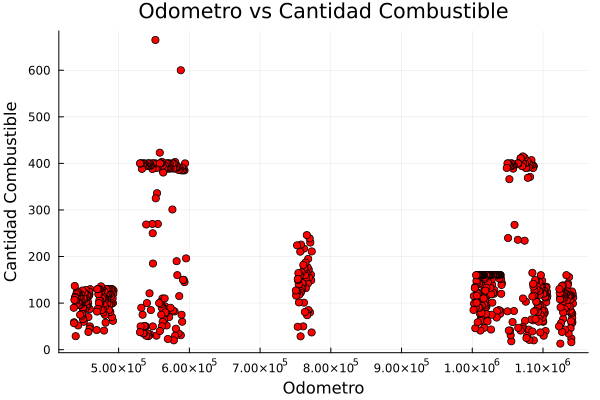

In [109]:
scatter(df.Odometro, df.Cantidad, title="Odometro vs Cantidad Combustible", xlabel="Odometro", ylabel="Cantidad Combustible", legend=false, color="red")

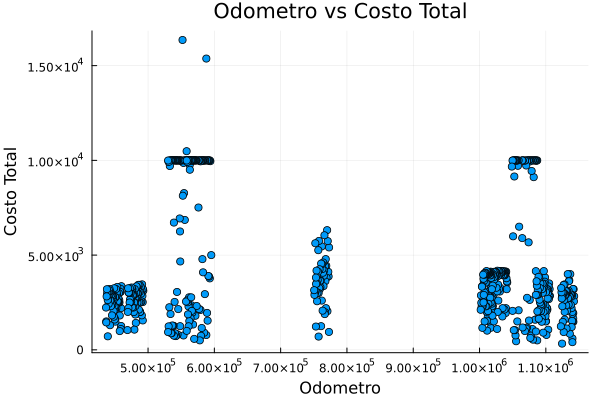

In [93]:
scatter(df.Odometro, df.Costo_Total, title="Odometro vs Costo Total", xlabel="Odometro", ylabel="Costo Total", legend=false)

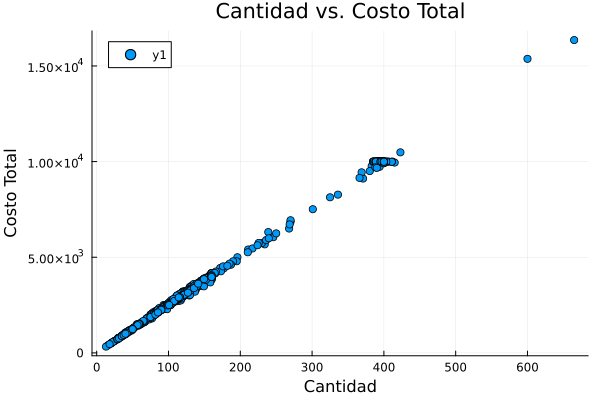

In [104]:
scatter(df.Cantidad, df.Costo_Total, title="Cantidad vs. Costo Total", xlabel="Cantidad", ylabel="Costo Total")

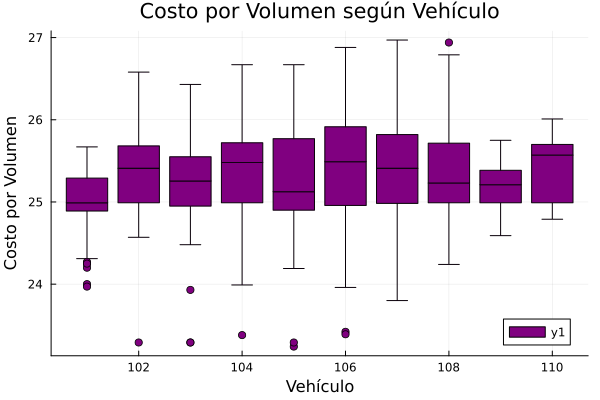

In [110]:
boxplot(df.Vehiculo, df.Costo_Por_Volumen, title="Costo por Volumen según Vehículo", xlabel="Vehículo", ylabel="Costo por Volumen", color="purple")

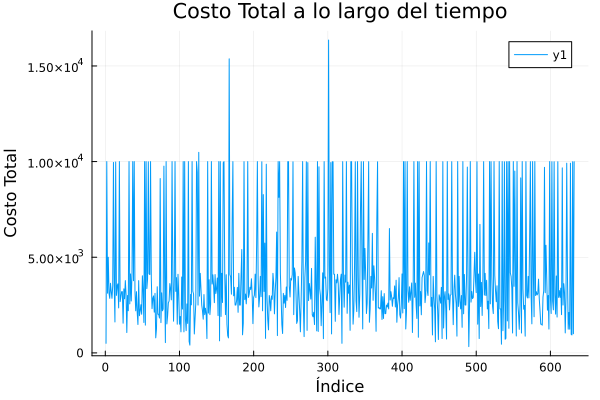

In [105]:
plot(1:nrow(df), df.Costo_Total, title="Costo Total a lo largo del tiempo", xlabel="Índice", ylabel="Costo Total")


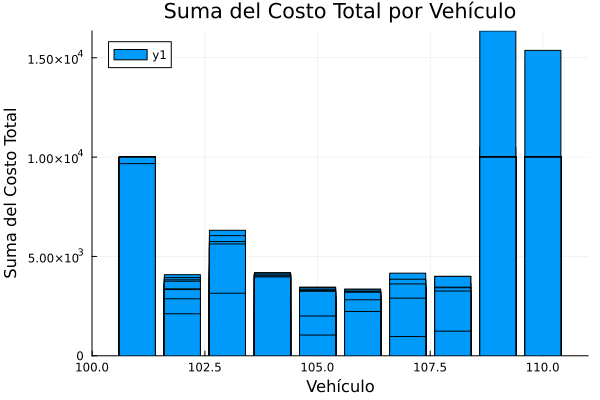

In [106]:
bar(df.Vehiculo, df.Costo_Total, title="Suma del Costo Total por Vehículo", xlabel="Vehículo", ylabel="Suma del Costo Total")

# PCA
Principal Component Analysis

# Función de regresión lineal
Predeciremos la cantidad usando el 
Odometro

Tanque_Lleno

Costo_Total

## Hipótesis

In [96]:
# hyp
theta = [float(rand(1:100)), float(rand(1:100)), float(rand(1:100))]
bias = [float(rand(1:100))]

function hyp(bias::Vector{Float64},theta::Vector{Float64}, sample::DataFrame)
    return bias[1] + sum(theta[i]*sample[i] + )
end

Base.Meta.ParseError: ParseError:
# Error @ /home/sen/tec/juliaProject/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X30sdnNjb2RlLXJlbW90ZQ==.jl:6:47
function hyp(bias::Vector{Float64},theta::Vector{Float64}, sample::DataFrame)
    return bias[1] + sum(theta[i]*sample[i] + )
#                                             ╙ ── unexpected `)`

## Separating Data - Train - Test

In [97]:
# 90% for training
train_ratio = 0.9

# Calcular el número de muestras para el conjunto de entrenamiento
n_train = floor(Int, train_ratio * nrow(shuffled_df))

# Separar los índices en entrenamiento y prueba
train_df = shuffled_df[1:n_train, :]
test_df = shuffled_df[(n_train+1):end, :]

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Bool,Float32,Float32,Float32
1,110,566806,true,24.99,400.0,9996.0
2,110,588977,true,26.0,75.0,1950.0
3,104,1028673,false,25.99,160.0,4158.0
4,104,1024085,true,25.69,160.0,4110.0
5,108,1138220,false,25.07,116.0,2908.0
6,110,562265,true,25.29,395.37,9999.0
7,109,540854,true,25.0,35.0,875.0
8,109,536461,true,25.22,51.0,1286.0
9,109,560066,true,25.57,391.0,9999.0


In [98]:
size(train_df)

(568, 6)

In [99]:
size(test_df)

(64, 6)

In [100]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Abstract…,Real,Float64,Real,Int64,DataType
1,Vehiculo,105.566,101,105.0,110,0,Int64
2,Odometro,8.12749e5,436624,1.0034e6,1142707,0,Int64
3,Tanque_Lleno,0.800633,false,1.0,true,0,Bool
4,Costo_Por_Volumen,25.2959,23.24,25.29,26.97,0,Float32
5,Cantidad,160.645,13.0,120.025,665.0,0,Float32
6,Costo_Total,4058.61,329.0,3055.5,16353.0,0,Float32
